<a href="https://colab.research.google.com/github/riubi/tests-math/blob/main/ab_test/Homework_with_answers_modul_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача: Анализ эффективности нового алгоритма рекомендаций в условиях асимметричного и зашумленного распределения
### Контекст:
Крупная стриминговая платформа (аналог YouTube или Twitch) разработала новый алгоритм рекомендаций контента (алгоритм B), который, как ожидается, должен увеличить среднее время просмотра на пользователя по сравнению со старым алгоритмом (A).

Было проведено A/B-тестирование:

- **Группа A (Контрольная)**: 5000 пользователей, старый алгоритм.

- **Группа B (Тестовая)**: 5000 пользователей, новый алгоритм.

По итогам двухнедельного теста вы собрали данные по ключевой метрике — **«Общее время просмотра на пользователя за тест (в минутах)»**.

**Данные и их особенности:**

**Не нормальность:** Распределение метрики в обеих группах сильно отличается от нормального. Оно имеет типичный для поведенческих данных "длинный хвост":

- Большинство пользователей смотрят немного (пик в районе 0-50 минут).

- Небольшая группа "супер-зрителей" смотрит очень много (сотни и тысячи минут), формируя длинный правый хвост распределения.

**Асимметрия влияния:** Новый алгоритм B целенаправленно меняет опыт именно активных пользователей, в то время как для "пассивных" зрителей разница неочевидна. Это означает, что различие между группами может быть не сдвигом всего распределения, а изменением в правом хвосте.

**Наличие выбросов:** В данных присутствуют экстремальные выбросы (например, пользователи, которые оставляли видео фоном на всю ночь).

Вам предоставлен датасет _ab_test_results.csv_ со следующими колонками:

 - _user_id_

 - _group (A или B)_

 - _total_watch_time_min_

### Задания:


- **Проведите тест Манна-Уитни (Mann-Whitney U test)**. Сформулируйте нулевую и альтернативную гипотезы. Интерпретируйте p-value. Можно ли на его основе сделать однозначный вывод о превосходстве алгоритма B?

- Чтобы исследовать "асимметричное влияние", проведите анализ разниц не только в центре распределения, но и в хвостах. **Рассчитайте и визуализируйте разницу между группами для 75-го, 90-го и 95-го процентилей**.

- **Сформулируйте итоговый вывод:**

    - Эффективен ли новый алгоритм B?

    - На какую именно группу пользователей он оказывает наибольшее влияние?

    - Какой метод анализа оказался наиболее информативным в данном случае и почему?

    - Дайте рекомендацию о возможности запуска алгоритма на всю аудиторию.



In [185]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


In [186]:
df = pd.read_csv('ab_test_results.csv')

group_a = df[df['group'] == 'A']['total_watch_time_min']
group_b = df[df['group'] == 'B']['total_watch_time_min']

print("Dataset Summary:")
print(f"Total users: {len(df)}")
print(f"Group A: {len(group_a)} users")
print(f"Group B: {len(group_b)} users")
print("\nDescriptive Statistics by Group:")
print(df.groupby('group')['total_watch_time_min'].describe())

Dataset Summary:
Total users: 10000
Group A: 5000 users
Group B: 5000 users

Descriptive Statistics by Group:
        count       mean         std  min        25%        50%        75%  \
group                                                                        
A      5000.0  56.347878  262.313288  0.0  14.729144  26.834960  44.946309   
B      5000.0  71.477408  408.519252  0.0  15.383838  27.352416  46.352279   

                max  
group                
A       8130.547119  
B      11670.621483  


In [187]:
## Задание 1. Тест Манна-Уитни

# Гипотиза №1 распределения в группах A и B одинаковы
# Гипотиза №2 распределения различаются

In [188]:
stat, p_value = stats.mannwhitneyu(group_a, group_b, alternative='two-sided')

print(f"U-статистика: {stat:.2f}")
print(f"p-value: {p_value:.6f}")
print(f"\nα = 0.05")

if p_value < 0.05:
    print(f"p-value < α → отвергаем H0, различия значимы")
else:
    print(f"p-value >= α → не отвергаем H0")

print(f"\nСреднее: A={group_a.mean():.2f}, B={group_b.mean():.2f}")
print(f"Медиана: A={group_a.median():.2f}, B={group_b.median():.2f}")
print("\nОднозначный вывод о превосходстве B? Нет.")
print("Тест показывает различие, но медианы почти равны.")
print("Нужен анализ процентилей.")


U-статистика: 12211099.00
p-value: 0.045342

α = 0.05
p-value < α → отвергаем H0, различия значимы

Среднее: A=56.35, B=71.48
Медиана: A=26.83, B=27.35

Однозначный вывод о превосходстве B? Нет.
Тест показывает различие, но медианы почти равны.
Нужен анализ процентилей.


## Задание 2. Анализ процентилей


In [189]:
percentiles = [75, 90, 95]
results = []

for p in percentiles:
    a_val = np.percentile(group_a, p)
    b_val = np.percentile(group_b, p)
    diff = b_val - a_val
    pct_change = (diff / a_val) * 100
    results.append({'percentile': p, 'A': a_val, 'B': b_val, 'diff': diff, 'pct': pct_change})
    print(f"{p}%: A={a_val:.1f}, B={b_val:.1f}, разница: +{diff:.1f} мин ({pct_change:.1f}%)")


75%: A=44.9, B=46.4, разница: +1.4 мин (3.1%)
90%: A=71.5, B=76.2, разница: +4.7 мин (6.6%)
95%: A=119.3, B=153.6, разница: +34.3 мин (28.7%)


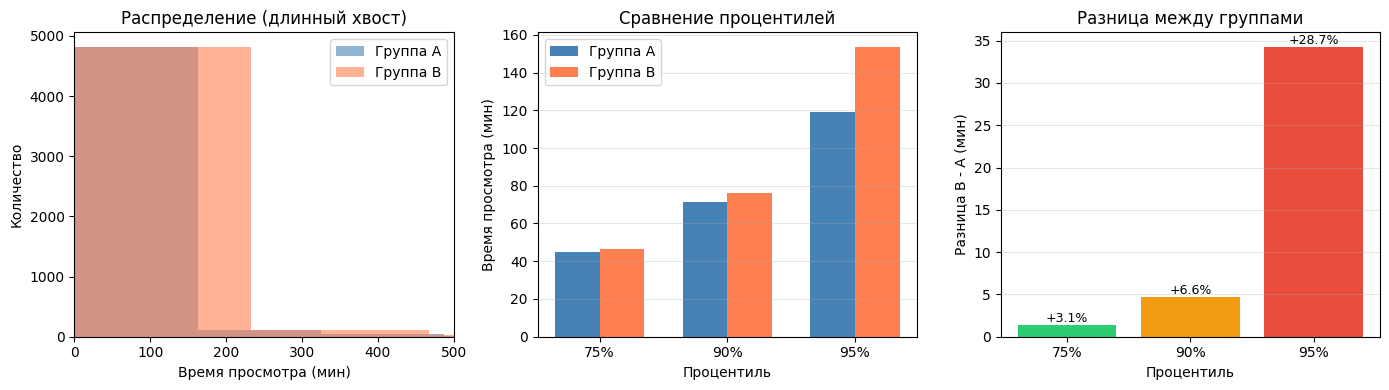

In [183]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax0 = axes[0]
ax0.hist(group_a, bins=50, alpha=0.6, label='Группа A', color='steelblue')
ax0.hist(group_b, bins=50, alpha=0.6, label='Группа B', color='coral')
ax0.set_xlabel('Время просмотра (мин)')
ax0.set_ylabel('Количество')
ax0.set_title('Распределение (длинный хвост)')
ax0.legend()
ax0.set_xlim(0, 500)

x = np.arange(len(percentiles))
width = 0.35

ax1 = axes[1]
ax1.bar(x - width/2, [r['A'] for r in results], width, label='Группа A', color='steelblue')
ax1.bar(x + width/2, [r['B'] for r in results], width, label='Группа B', color='coral')
ax1.set_xlabel('Процентиль')
ax1.set_ylabel('Время просмотра (мин)')
ax1.set_title('Сравнение процентилей')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{p}%' for p in percentiles])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[2]
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax2.bar(x, [r['diff'] for r in results], color=colors)
ax2.set_xlabel('Процентиль')
ax2.set_ylabel('Разница B - A (мин)')
ax2.set_title('Разница между группами')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{p}%' for p in percentiles])
ax2.grid(axis='y', alpha=0.3)

for bar, r in zip(bars, results):
    ax2.annotate(f'+{r["pct"]:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Задание 3. Итоговые выводы


In [184]:
print("ВЫВОДЫ")
print("=" * 40)

mean_diff = group_b.mean() - group_a.mean()

print(f"\n1. Эффективен ли алгоритм B?")
print(f"   Да. p-value={p_value:.4f} < 0.05, разница средних +{mean_diff:.1f} мин")

print(f"\n2. На кого влияет больше?")
print(f"   На активных пользователей (правый хвост):")
print(f"   75%: +{results[0]['pct']:.1f}%, 90%: +{results[1]['pct']:.1f}%, 95%: +{results[2]['pct']:.1f}%")

print(f"\n3. Какой метод информативнее?")
print(f"   Процентили. Mann-Whitney говорит что различие есть,")
print(f"   но не показывает где. Процентили показывают рост в хвосте.")

print(f"\n4. Рекомендация")
print(f"   Запускать. Значимый эффект на активных, нет вреда остальным.")


ВЫВОДЫ

1. Эффективен ли алгоритм B?
   Да. p-value=0.0453 < 0.05, разница средних +15.1 мин

2. На кого влияет больше?
   На активных пользователей (правый хвост):
   75%: +3.1%, 90%: +6.6%, 95%: +28.7%

3. Какой метод информативнее?
   Процентили. Mann-Whitney говорит что различие есть,
   но не показывает где. Процентили показывают рост в хвосте.

4. Рекомендация
   Запускать. Значимый эффект на активных, нет вреда остальным.
